In [50]:
import pandas as pd
import numpy as np
import ipaddress
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
import tensorflow as tf
import scikeras
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

train_dataset_path = 'dataset/Wednesday-workingHours.pcap_ISCX.csv'
test_dataset_path = 'dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'

train_data = pd.read_csv(train_dataset_path)
test_data = pd.read_csv(test_dataset_path)



In [51]:
def convert_ip2int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0  # Return 0 for invalid IP addresses    

def preprocess_data(data):
    df = data.copy()
    df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
    
    df['Source_IP'] = df['Source_IP'].apply(convert_ip2int)
    df['Destination_IP'] = df['Destination_IP'].apply(convert_ip2int)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce').astype(np.int64)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    y = np.where(df['Label'] == 'BENIGN', 0, 1)
    X = df.drop('Label', axis=1)
    X = X.select_dtypes(include=np.number)
    return X, y
# 위의 과정을 통해 Flow ID라는 int 형태가 될 수 없는 데이터와
# y로 분리되어 있는 Label을 제외한 나머지 데이터는 모두 숫자형으로 변환된다.

X_train, y_train = preprocess_data(train_data)
X_test, y_test = preprocess_data(test_data)

print(f"Train 데이터 크기: {X_train.shape}")
print(f"Test 데이터 크기: {X_test.shape}")
print("-" * 50)

Train 데이터 크기: (692703, 83)
Test 데이터 크기: (225745, 83)
--------------------------------------------------


In [52]:

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LSTM 입력 형태에 맞게 데이터 재구성 (samples, timesteps, features)
# 여기서는 각 샘플을 1개의 타임스텝으로 간주
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

def create_lstm_model(lstm_units=100, dense_units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(lstm_units, activation='relu',
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model




In [53]:
# 가중치 부여
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

print(f"클래스 가중치: {class_weights_dict}")

클래스 가중치: {0: 0.7871070447309394, 1: 1.3707553666413375}


In [54]:

# LSTM 모델 정의
lstm_model = KerasClassifier(build_fn=create_lstm_model)

grid_params = {
    'epochs': [10, 25, 50],
    'batch_size': [32, 64]
}
grid_search = GridSearchCV(estimator=lstm_model, param_grid=grid_params, cv=3, scoring='f1' , verbose=1)
grid_search.fit(X_train_lstm, y_train, class_weight=class_weights_dict)

print("최적의 파라미터:", grid_search.best_params_)
lstm_best_model = grid_search.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14432/14432 [==============================] - 44s 3ms/step - loss: 0.0028 - accuracy: 0.9993
Epoch 2/10
14432/14432 [==============================] - 43s 3ms/step - loss: 4.0914e-04 - accuracy: 0.9999
Epoch 3/10
14432/14432 [==============================] - 42s 3ms/step - loss: 2.0179e-04 - accuracy: 1.0000
Epoch 4/10
14432/14432 [==============================] - 43s 3ms/step - loss: 1.9808e-04 - accuracy: 1.0000
Epoch 5/10
14432/14432 [==============================] - 43s 3ms/step - loss: 1.4546e-04 - accuracy: 1.0000
Epoch 6/10
14432/14432 [==============================] - 43s 3ms/step - loss: 3.0675e-04 - accuracy: 1.0000
Epoch 7/10
14432/14432 [==============================] - 43s 3ms/step - loss: 1.1368e-04 - accuracy: 1.0000
Epoch 8/10
14432/14432 [==============================] - 43s 3ms/step - loss: 1.3977e-04 - accuracy: 1.0000
Epoch 9/10
14432/14432 [==============================] - 43s 3ms/step - loss: 5.4056e-05 - accuracy: 1.0000
Epoch 10/10
7216/7216 [

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14432/14432 [==============================] - 43s 3ms/step - loss: 0.0049 - accuracy: 0.9987
Epoch 2/10
14432/14432 [==============================] - 42s 3ms/step - loss: 6.5870e-04 - accuracy: 0.9999
Epoch 3/10
14432/14432 [==============================] - 42s 3ms/step - loss: 3.7424e-04 - accuracy: 0.9999
Epoch 4/10
14432/14432 [==============================] - 42s 3ms/step - loss: 3.9870e-04 - accuracy: 1.0000
Epoch 5/10
14432/14432 [==============================] - 42s 3ms/step - loss: 3.2644e-04 - accuracy: 1.0000
Epoch 6/10
14432/14432 [==============================] - 42s 3ms/step - loss: 1.5224e-04 - accuracy: 1.0000
Epoch 7/10
14432/14432 [==============================] - 42s 3ms/step - loss: 4.2121e-04 - accuracy: 1.0000
Epoch 8/10
14432/14432 [==============================] - 42s 3ms/step - loss: 3.6448e-05 - accuracy: 1.0000
Epoch 9/10
14432/14432 [==============================] - 42s 3ms/step - loss: 3.5455e-04 - accuracy: 1.0000
Epoch 10/10
7216/7216 [

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
14432/14432 [==============================] - 42s 3ms/step - loss: 0.0040 - accuracy: 0.9990
Epoch 2/10
14432/14432 [==============================] - 40s 3ms/step - loss: 4.8600e-04 - accuracy: 0.9999
Epoch 3/10
14432/14432 [==============================] - 41s 3ms/step - loss: 4.8276e-04 - accuracy: 0.9999
Epoch 4/10
14432/14432 [==============================] - 41s 3ms/step - loss: 4.8029e-04 - accuracy: 1.0000
Epoch 5/10
14432/14432 [==============================] - 41s 3ms/step - loss: 2.6048e-04 - accuracy: 1.0000
Epoch 6/10
14432/14432 [==============================] - 41s 3ms/step - loss: 2.0723e-04 - accuracy: 1.0000
Epoch 7/10
14432/14432 [==============================] - 41s 3ms/step - loss: 1.5809e-04 - accuracy: 1.0000
Epoch 8/10
14432/14432 [==============================] - 40s 3ms/step - loss: 4.0940e-04 - accuracy: 1.0000
Epoch 9/10
14432/14432 [==============================] - 41s 3ms/step - loss: 1.5529e-04 - accuracy: 1.0000
Epoch 10/10
7216/7216 [

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
14432/14432 [==============================] - 40s 3ms/step - loss: 0.0028 - accuracy: 0.9993
Epoch 2/25
14432/14432 [==============================] - 39s 3ms/step - loss: 4.2173e-04 - accuracy: 0.9999
Epoch 3/25
14432/14432 [==============================] - 39s 3ms/step - loss: 1.5777e-04 - accuracy: 1.0000
Epoch 4/25
14432/14432 [==============================] - 39s 3ms/step - loss: 2.8557e-04 - accuracy: 1.0000
Epoch 5/25
14432/14432 [==============================] - 39s 3ms/step - loss: 2.3032e-04 - accuracy: 1.0000
Epoch 6/25
14432/14432 [==============================] - 39s 3ms/step - loss: 1.8344e-04 - accuracy: 1.0000
Epoch 7/25
14432/14432 [==============================] - 39s 3ms/step - loss: 2.4908e-04 - accuracy: 1.0000
Epoch 8/25
14432/14432 [==============================] - 39s 3ms/step - loss: 1.9119e-04 - accuracy: 1.0000
Epoch 9/25
14432/14432 [==============================] - 39s 3ms/step - loss: 4.5646e-05 - accuracy: 1.0000
Epoch 10/25
14432/14432

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
14432/14432 [==============================] - 44s 3ms/step - loss: 0.0048 - accuracy: 0.9988
Epoch 2/25
14432/14432 [==============================] - 42s 3ms/step - loss: 4.5803e-04 - accuracy: 0.9999
Epoch 3/25
14432/14432 [==============================] - 42s 3ms/step - loss: 4.3817e-04 - accuracy: 1.0000
Epoch 4/25
14432/14432 [==============================] - 42s 3ms/step - loss: 3.7532e-04 - accuracy: 1.0000
Epoch 5/25
14432/14432 [==============================] - 42s 3ms/step - loss: 2.9308e-04 - accuracy: 1.0000
Epoch 6/25
14432/14432 [==============================] - 42s 3ms/step - loss: 4.1465e-04 - accuracy: 1.0000
Epoch 7/25
14432/14432 [==============================] - 42s 3ms/step - loss: 3.4390e-04 - accuracy: 1.0000
Epoch 8/25
14432/14432 [==============================] - 42s 3ms/step - loss: 2.3985e-04 - accuracy: 1.0000
Epoch 9/25
14432/14432 [==============================] - 42s 3ms/step - loss: 1.9044e-04 - accuracy: 1.0000
Epoch 10/25
14432/14432

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
14432/14432 [==============================] - 42s 3ms/step - loss: 0.0041 - accuracy: 0.9989
Epoch 2/25
14432/14432 [==============================] - 41s 3ms/step - loss: 5.5522e-04 - accuracy: 0.9999
Epoch 3/25
14432/14432 [==============================] - 41s 3ms/step - loss: 2.8156e-04 - accuracy: 1.0000
Epoch 4/25
14432/14432 [==============================] - 41s 3ms/step - loss: 1.2079e-04 - accuracy: 1.0000
Epoch 5/25
14432/14432 [==============================] - 41s 3ms/step - loss: 6.0940e-04 - accuracy: 1.0000
Epoch 6/25
14432/14432 [==============================] - 41s 3ms/step - loss: 3.8657e-04 - accuracy: 1.0000
Epoch 7/25
14432/14432 [==============================] - 41s 3ms/step - loss: 1.9778e-04 - accuracy: 1.0000
Epoch 8/25
14432/14432 [==============================] - 41s 3ms/step - loss: 1.7211e-04 - accuracy: 1.0000
Epoch 9/25
14432/14432 [==============================] - 41s 3ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 10/25
14432/14432 [==

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14432/14432 [==============================] - 39s 3ms/step - loss: 0.0029 - accuracy: 0.9992
Epoch 2/50
14432/14432 [==============================] - 38s 3ms/step - loss: 2.1383e-04 - accuracy: 1.0000
Epoch 3/50
14432/14432 [==============================] - 38s 3ms/step - loss: 1.9130e-04 - accuracy: 1.0000
Epoch 4/50
14432/14432 [==============================] - 38s 3ms/step - loss: 4.3926e-04 - accuracy: 0.9999
Epoch 5/50
14432/14432 [==============================] - 38s 3ms/step - loss: 2.3526e-04 - accuracy: 1.0000
Epoch 6/50
14432/14432 [==============================] - 38s 3ms/step - loss: 2.9420e-04 - accuracy: 1.0000
Epoch 7/50
14432/14432 [==============================] - 38s 3ms/step - loss: 2.6962e-04 - accuracy: 1.0000
Epoch 8/50
14432/14432 [==============================] - 38s 3ms/step - loss: 3.0201e-04 - accuracy: 1.0000
Epoch 9/50
14432/14432 [==============================] - 38s 3ms/step - loss: 2.8894e-04 - accuracy: 1.0000
Epoch 10/50
14432/14432

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14432/14432 [==============================] - 41s 3ms/step - loss: 0.0051 - accuracy: 0.9985
Epoch 2/50
14432/14432 [==============================] - 40s 3ms/step - loss: 5.7045e-04 - accuracy: 0.9999
Epoch 3/50
14432/14432 [==============================] - 40s 3ms/step - loss: 4.9318e-04 - accuracy: 0.9999
Epoch 4/50
14432/14432 [==============================] - 41s 3ms/step - loss: 5.8220e-04 - accuracy: 0.9999
Epoch 5/50
14432/14432 [==============================] - 41s 3ms/step - loss: 1.3834e-04 - accuracy: 1.0000
Epoch 6/50
14432/14432 [==============================] - 40s 3ms/step - loss: 1.5679e-04 - accuracy: 1.0000
Epoch 7/50
14432/14432 [==============================] - 41s 3ms/step - loss: 3.6730e-04 - accuracy: 0.9999
Epoch 8/50
14432/14432 [==============================] - 41s 3ms/step - loss: 6.8029e-04 - accuracy: 1.0000
Epoch 9/50
14432/14432 [==============================] - 40s 3ms/step - loss: 4.2071e-04 - accuracy: 1.0000
Epoch 10/50
14432/14432

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
14432/14432 [==============================] - 51s 3ms/step - loss: 0.0040 - accuracy: 0.9989
Epoch 2/50
14432/14432 [==============================] - 50s 3ms/step - loss: 5.7308e-04 - accuracy: 0.9999
Epoch 3/50
14432/14432 [==============================] - 50s 3ms/step - loss: 3.6902e-04 - accuracy: 0.9999
Epoch 4/50
14432/14432 [==============================] - 50s 3ms/step - loss: 3.2141e-04 - accuracy: 1.0000
Epoch 5/50
14432/14432 [==============================] - 50s 3ms/step - loss: 4.1832e-04 - accuracy: 1.0000
Epoch 6/50
14432/14432 [==============================] - 50s 3ms/step - loss: 9.8180e-05 - accuracy: 1.0000
Epoch 7/50
14432/14432 [==============================] - 50s 3ms/step - loss: 3.9465e-04 - accuracy: 1.0000
Epoch 8/50
14432/14432 [==============================] - 50s 3ms/step - loss: 7.9041e-05 - accuracy: 1.0000
Epoch 9/50
14432/14432 [==============================] - 50s 3ms/step - loss: 3.2879e-04 - accuracy: 1.0000
Epoch 10/50
14432/14432

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7216/7216 [==============================] - 36s 5ms/step - loss: 0.0047 - accuracy: 0.9986
Epoch 2/10
7216/7216 [==============================] - 35s 5ms/step - loss: 3.0281e-04 - accuracy: 0.9999
Epoch 3/10
7216/7216 [==============================] - 35s 5ms/step - loss: 1.8318e-04 - accuracy: 1.0000
Epoch 4/10
7216/7216 [==============================] - 35s 5ms/step - loss: 1.4866e-04 - accuracy: 1.0000
Epoch 5/10
7216/7216 [==============================] - 35s 5ms/step - loss: 1.1121e-04 - accuracy: 1.0000
Epoch 6/10
7216/7216 [==============================] - 34s 5ms/step - loss: 8.3812e-05 - accuracy: 1.0000
Epoch 7/10
7216/7216 [==============================] - 35s 5ms/step - loss: 9.4214e-05 - accuracy: 1.0000
Epoch 8/10
7216/7216 [==============================] - 34s 5ms/step - loss: 1.1331e-04 - accuracy: 1.0000
Epoch 9/10
7216/7216 [==============================] - 34s 5ms/step - loss: 8.4159e-05 - accuracy: 1.0000
Epoch 10/10
3608/3608 [==================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7216/7216 [==============================] - 34s 5ms/step - loss: 0.0069 - accuracy: 0.9979
Epoch 2/10
7216/7216 [==============================] - 33s 5ms/step - loss: 4.5437e-04 - accuracy: 0.9999
Epoch 3/10
7216/7216 [==============================] - 33s 5ms/step - loss: 1.6697e-04 - accuracy: 1.0000
Epoch 4/10
7216/7216 [==============================] - 33s 5ms/step - loss: 3.4968e-04 - accuracy: 0.9999
Epoch 5/10
7216/7216 [==============================] - 33s 5ms/step - loss: 1.1848e-04 - accuracy: 1.0000
Epoch 6/10
7216/7216 [==============================] - 33s 5ms/step - loss: 1.3802e-04 - accuracy: 1.0000
Epoch 7/10
7216/7216 [==============================] - 33s 5ms/step - loss: 5.1102e-05 - accuracy: 1.0000
Epoch 8/10
7216/7216 [==============================] - 33s 5ms/step - loss: 1.9032e-04 - accuracy: 1.0000
Epoch 9/10
7216/7216 [==============================] - 33s 5ms/step - loss: 2.3704e-04 - accuracy: 1.0000
Epoch 10/10
3608/3608 [==================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
7216/7216 [==============================] - 35s 5ms/step - loss: 0.0054 - accuracy: 0.9985
Epoch 2/10
7216/7216 [==============================] - 34s 5ms/step - loss: 4.7106e-04 - accuracy: 0.9999
Epoch 3/10
7216/7216 [==============================] - 34s 5ms/step - loss: 2.7448e-04 - accuracy: 1.0000
Epoch 4/10
7216/7216 [==============================] - 34s 5ms/step - loss: 2.2846e-04 - accuracy: 1.0000
Epoch 5/10
7216/7216 [==============================] - 34s 5ms/step - loss: 3.6483e-04 - accuracy: 0.9999
Epoch 6/10
7216/7216 [==============================] - 34s 5ms/step - loss: 1.5571e-04 - accuracy: 1.0000
Epoch 7/10
7216/7216 [==============================] - 34s 5ms/step - loss: 1.3768e-04 - accuracy: 1.0000
Epoch 8/10
7216/7216 [==============================] - 34s 5ms/step - loss: 6.6099e-05 - accuracy: 1.0000
Epoch 9/10
7216/7216 [==============================] - 34s 5ms/step - loss: 3.9860e-05 - accuracy: 1.0000
Epoch 10/10
3608/3608 [==================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
7216/7216 [==============================] - 40s 5ms/step - loss: 0.0040 - accuracy: 0.9988
Epoch 2/25
7216/7216 [==============================] - 39s 5ms/step - loss: 4.1112e-04 - accuracy: 0.9999
Epoch 3/25
7216/7216 [==============================] - 39s 5ms/step - loss: 1.3310e-04 - accuracy: 1.0000
Epoch 4/25
7216/7216 [==============================] - 39s 5ms/step - loss: 2.4466e-04 - accuracy: 1.0000
Epoch 5/25
7216/7216 [==============================] - 39s 5ms/step - loss: 2.0770e-04 - accuracy: 1.0000
Epoch 6/25
7216/7216 [==============================] - 39s 5ms/step - loss: 1.9134e-04 - accuracy: 1.0000
Epoch 7/25
7216/7216 [==============================] - 39s 5ms/step - loss: 1.0061e-04 - accuracy: 1.0000
Epoch 8/25
7216/7216 [==============================] - 39s 5ms/step - loss: 1.0564e-04 - accuracy: 1.0000
Epoch 9/25
7216/7216 [==============================] - 39s 5ms/step - loss: 1.3192e-04 - accuracy: 1.0000
Epoch 10/25
7216/7216 [==================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
7216/7216 [==============================] - 39s 5ms/step - loss: 0.0062 - accuracy: 0.9983
Epoch 2/25
7216/7216 [==============================] - 37s 5ms/step - loss: 6.0656e-04 - accuracy: 0.9999
Epoch 3/25
7216/7216 [==============================] - 37s 5ms/step - loss: 3.2767e-04 - accuracy: 0.9999
Epoch 4/25
7216/7216 [==============================] - 37s 5ms/step - loss: 2.3726e-04 - accuracy: 1.0000
Epoch 5/25
7216/7216 [==============================] - 37s 5ms/step - loss: 9.6351e-05 - accuracy: 1.0000
Epoch 6/25
7216/7216 [==============================] - 37s 5ms/step - loss: 3.5360e-04 - accuracy: 0.9999
Epoch 7/25
7216/7216 [==============================] - 37s 5ms/step - loss: 1.7945e-04 - accuracy: 1.0000
Epoch 8/25
7216/7216 [==============================] - 37s 5ms/step - loss: 1.3519e-05 - accuracy: 1.0000
Epoch 9/25
7216/7216 [==============================] - 37s 5ms/step - loss: 8.0491e-05 - accuracy: 1.0000
Epoch 10/25
7216/7216 [==================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
7216/7216 [==============================] - 37s 5ms/step - loss: 0.0054 - accuracy: 0.9985
Epoch 2/25
7216/7216 [==============================] - 36s 5ms/step - loss: 5.3193e-04 - accuracy: 0.9999
Epoch 3/25
7216/7216 [==============================] - 36s 5ms/step - loss: 2.0460e-04 - accuracy: 1.0000
Epoch 4/25
7216/7216 [==============================] - 36s 5ms/step - loss: 2.4048e-04 - accuracy: 1.0000
Epoch 5/25
7216/7216 [==============================] - 36s 5ms/step - loss: 7.8758e-06 - accuracy: 1.0000
Epoch 6/25
7216/7216 [==============================] - 36s 5ms/step - loss: 3.8097e-04 - accuracy: 0.9999
Epoch 7/25
7216/7216 [==============================] - 36s 5ms/step - loss: 1.1491e-04 - accuracy: 1.0000
Epoch 8/25
7216/7216 [==============================] - 36s 5ms/step - loss: 3.4084e-06 - accuracy: 1.0000
Epoch 9/25
7216/7216 [==============================] - 36s 5ms/step - loss: 1.1300e-04 - accuracy: 1.0000
Epoch 10/25
7216/7216 [==================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7216/7216 [==============================] - 36s 5ms/step - loss: 0.0039 - accuracy: 0.9992
Epoch 2/50
7216/7216 [==============================] - 35s 5ms/step - loss: 3.6825e-04 - accuracy: 0.9999
Epoch 3/50
7216/7216 [==============================] - 35s 5ms/step - loss: 2.0233e-04 - accuracy: 1.0000
Epoch 4/50
7216/7216 [==============================] - 35s 5ms/step - loss: 1.0959e-04 - accuracy: 1.0000
Epoch 5/50
7216/7216 [==============================] - 35s 5ms/step - loss: 5.8682e-05 - accuracy: 1.0000
Epoch 6/50
7216/7216 [==============================] - 35s 5ms/step - loss: 4.1801e-04 - accuracy: 1.0000
Epoch 7/50
7216/7216 [==============================] - 35s 5ms/step - loss: 1.0461e-04 - accuracy: 1.0000
Epoch 8/50
7216/7216 [==============================] - 35s 5ms/step - loss: 9.7733e-05 - accuracy: 1.0000
Epoch 9/50
7216/7216 [==============================] - 35s 5ms/step - loss: 3.5746e-05 - accuracy: 1.0000
Epoch 10/50
7216/7216 [==================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7216/7216 [==============================] - 36s 5ms/step - loss: 0.0066 - accuracy: 0.9979
Epoch 2/50
7216/7216 [==============================] - 35s 5ms/step - loss: 4.5427e-04 - accuracy: 0.9999
Epoch 3/50
7216/7216 [==============================] - 35s 5ms/step - loss: 2.5149e-04 - accuracy: 1.0000
Epoch 4/50
7216/7216 [==============================] - 35s 5ms/step - loss: 4.0302e-04 - accuracy: 0.9999
Epoch 5/50
7216/7216 [==============================] - 35s 5ms/step - loss: 2.2809e-04 - accuracy: 1.0000
Epoch 6/50
7216/7216 [==============================] - 35s 5ms/step - loss: 3.0718e-04 - accuracy: 1.0000
Epoch 7/50
7216/7216 [==============================] - 36s 5ms/step - loss: 1.8611e-04 - accuracy: 1.0000
Epoch 8/50
7216/7216 [==============================] - 35s 5ms/step - loss: 1.7694e-04 - accuracy: 1.0000
Epoch 9/50
7216/7216 [==============================] - 35s 5ms/step - loss: 1.5915e-04 - accuracy: 1.0000
Epoch 10/50
7216/7216 [==================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
7216/7216 [==============================] - 44s 6ms/step - loss: 0.0056 - accuracy: 0.9984
Epoch 2/50
7216/7216 [==============================] - 43s 6ms/step - loss: 4.7902e-04 - accuracy: 0.9999
Epoch 3/50
7216/7216 [==============================] - 43s 6ms/step - loss: 3.2012e-04 - accuracy: 1.0000
Epoch 4/50
7216/7216 [==============================] - 43s 6ms/step - loss: 2.4228e-04 - accuracy: 1.0000
Epoch 5/50
7216/7216 [==============================] - 43s 6ms/step - loss: 1.8632e-04 - accuracy: 1.0000
Epoch 6/50
7216/7216 [==============================] - 43s 6ms/step - loss: 2.0511e-04 - accuracy: 1.0000
Epoch 7/50
7216/7216 [==============================] - 43s 6ms/step - loss: 1.7081e-04 - accuracy: 1.0000
Epoch 8/50
7216/7216 [==============================] - 43s 6ms/step - loss: 8.1543e-05 - accuracy: 1.0000
Epoch 9/50
7216/7216 [==============================] - 43s 6ms/step - loss: 5.2685e-05 - accuracy: 1.0000
Epoch 10/50
7216/7216 [==================

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
21647/21647 [==============================] - 87s 4ms/step - loss: 0.0034 - accuracy: 0.9992
Epoch 2/25
21647/21647 [==============================] - 86s 4ms/step - loss: 4.5670e-04 - accuracy: 0.9999
Epoch 3/25
21647/21647 [==============================] - 86s 4ms/step - loss: 4.1367e-04 - accuracy: 0.9999
Epoch 4/25
21647/21647 [==============================] - 86s 4ms/step - loss: 4.1249e-04 - accuracy: 1.0000
Epoch 5/25
21647/21647 [==============================] - 86s 4ms/step - loss: 1.7649e-04 - accuracy: 1.0000
Epoch 6/25
21647/21647 [==============================] - 86s 4ms/step - loss: 2.1460e-04 - accuracy: 1.0000
Epoch 7/25
21647/21647 [==============================] - 87s 4ms/step - loss: 1.4668e-04 - accuracy: 1.0000
Epoch 8/25
21647/21647 [==============================] - 87s 4ms/step - loss: 1.5886e-04 - accuracy: 1.0000
Epoch 9/25
21647/21647 [==============================] - 87s 4ms/step - loss: 2.2980e-05 - accuracy: 1.0000
Epoch 10/25
21647/21647

In [55]:
## 최적의 하이퍼파라미터로 재학습
import time

start_time = time.time()
lstm_best_model.fit(X_train_lstm, y_train, epochs=grid_search.best_params_['epochs'], batch_size=grid_search.best_params_['batch_size'], class_weight=class_weights_dict)
end_time = time.time()
print(f"모델 학습 시간: {end_time - start_time:.4f} 초")

c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/25
21647/21647 [==============================] - 85s 4ms/step - loss: 0.0033 - accuracy: 0.9991
Epoch 2/25
21647/21647 [==============================] - 84s 4ms/step - loss: 5.3860e-04 - accuracy: 0.9999
Epoch 3/25
21647/21647 [==============================] - 84s 4ms/step - loss: 4.3965e-04 - accuracy: 1.0000
Epoch 4/25
21647/21647 [==============================] - 83s 4ms/step - loss: 2.3629e-04 - accuracy: 1.0000
Epoch 5/25
21647/21647 [==============================] - 83s 4ms/step - loss: 4.4793e-04 - accuracy: 1.0000
Epoch 6/25
21647/21647 [==============================] - 84s 4ms/step - loss: 1.2655e-04 - accuracy: 1.0000
Epoch 7/25
21647/21647 [==============================] - 84s 4ms/step - loss: 3.7901e-04 - accuracy: 1.0000
Epoch 8/25
21647/21647 [==============================] - 84s 4ms/step - loss: 6.6608e-05 - accuracy: 1.0000
Epoch 9/25
21647/21647 [==============================] - 84s 4ms/step - loss: 1.9685e-04 - accuracy: 1.0000
Epoch 10/25
21647/21647

In [ ]:

# 모델 평가
#loss, accuracy = lstm_best_model.model_.evaluate(X_test_lstm, y_test, verbose=0)
y_pred_lstm_proba = lstm_best_model.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int)

print("[LSTM 모델 최적화 결과]")
print(f" - 하이퍼파라미터: {grid_search.best_params_}")
print(f" - 정확도 (Accuracy): {accuracy_score(y_test, y_pred_lstm):.4f}")
print(f" - 재현율 (Recall): {recall_score(y_test, y_pred_lstm):.4f}")
print(f" - 정밀도 (Precision): {precision_score(y_test, y_pred_lstm):.4f}")
print(f" - F1-Score: {f1_score(y_test, y_pred_lstm):.4f}")
print(f" - 학습 시간: {end_time - start_time:.4f}초")
print("-" * 50)



7055/7055 [==============================] - 8s 1ms/step
[LSTM 모델 최적화 결과]
 - 하이퍼파라미터: {'batch_size': 32, 'epochs': 25}
 - 정확도 (Accuracy): 0.5671
 - 재현율 (Recall): 1.0000
 - 정밀도 (Precision): 0.5671
 - F1-Score: 0.7238
 - 학습 시간: 2097.2536초
--------------------------------------------------


[예측 확률값 통계]
count    225745.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
dtype: float64


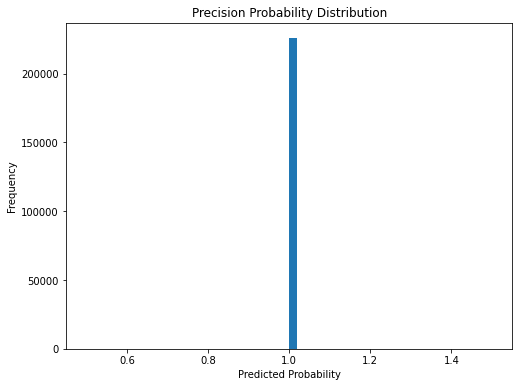

In [57]:

print("[예측 확률값 통계]")
print(pd.Series(y_pred_lstm_proba.flatten()).describe())

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(y_pred_lstm_proba, bins=50)
plt.title("Precision Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

Text(0.5, 1.0, 'ROC Curve for LSTM Model')

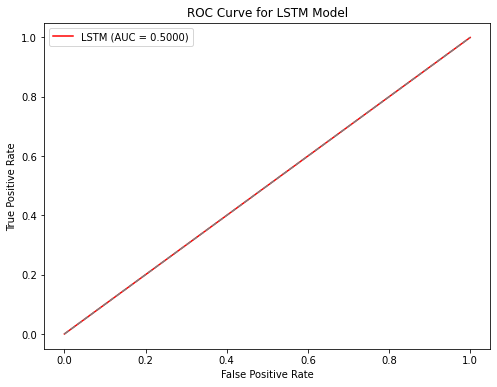

In [58]:
## ROC 곡선 및 AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_lstm_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'LSTM (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.legend()
plt.title('ROC Curve for LSTM Model')

In [59]:
import joblib
import os

save_path = 'models/lstm_model.h5'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

lstm_best_model.model_.save(save_path)
print(f"LSTM 모델이 {save_path}에 저장되었습니다.")


LSTM 모델이 models/lstm_model.h5에 저장되었습니다.


c:\Users\csp\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
